# Carbon Use Efficiency

Resources:
* Models: http://bigg.ucsd.edu/models/

In [134]:
import requests, cobra, tempfile, os, micom
from cue_tools import CUEDef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [79]:
def subsetCommunity(com, taxa):
    """
    Compute fluxes of a subset of a micom community, `com` to the list in `taxa`
    
    Discussion about approaches: 
        https://github.com/micom-dev/micom/issues/33#issuecomment-827149831
    """
    if isinstance(taxa, str):
        taxa = [taxa]
    # Remove tolerance to allow for 0 abundance
    com._rtol = 0
    # Create abundance series
    abunds = pd.Series({t: 1 if t in set(taxa) else 0 for t in com.taxa})
    com.set_abundance(abunds)

# Load

In [2]:
"""Download models locally"""
def downloadModels():
    if not os.path.isdir('models/'):
        os.makedirs('models/')
    with open('spp.txt', 'r') as f:
        IDS = f.readlines()
        for ID in IDS:
            ID = ID.strip()
            url = f'http://bigg.ucsd.edu/static/models/{ID}.mat'
            with requests.get(url) as resp:
                with open(f'models/{ID}.mat', 'wb') as o:
                    o.write(resp.content)

In [21]:
"""Setup MICOM community"""
# Don't load these models due to metabolite naming bugs
no = ['iJB785', 'iRC1080']
# Create input for MICOM
id_df = pd.read_csv('spp.txt', header=None, names=['id'])
id_df['file'] = 'models/'+id_df.id
# Filter out bad IDs
id_df = id_df[~id_df.id.isin(no)]
id_df

,id,file
0,iIT341,models/iIT341
1,iLJ478,models/iLJ478
2,iAF692,models/iAF692
3,iNF517,models/iNF517
4,iHN637,models/iHN637
6,iJN678,models/iJN678
7,iJN746,models/iJN746
8,iJR904,models/iJR904
9,iND750,models/iND750
10,iAF987,models/iAF987


In [7]:
"""Create multi-compartment 'Community' model"""
def buildCommunity(id_df):
    # ONLY FOR BUILDING COMMUNITY OBJECT, LOAD `community.pkl` directly in next cell for us
    # Build model
    com = micom.Community(id_df)
    # Pickle
    com.to_pickle('community.pkl')

In [107]:
"""Load community model"""
com = micom.load_pickle('community.pkl')
com

Name,None
Memory address,0x024515d5e108
Number of metabolites,8013
Number of reactions,9329
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"c__iIT341, e__iIT341, m, c__iLJ478, e__iLJ478, c__iAF692, e__iAF692, c__iNF517, e__iNF517, e__iHN637, c__iHN637, e__iJN678, c__iJN678, u__iJN678, p__iJN678, e__iJN746, c__iJN746, p__iJN746, c__iJR904, e__iJR904, e__iND750, x__iND750, c__iND750, m__iND750, n__iND750, r__iND750, g__iND750, v__iND750, e__iAF987, c__iAF987, p__iAF987"


In [214]:
com.medium

{'EX_pime_m': 10.0,
 'EX_phe__L_m': 0.02,
 'EX_pheme_m': 10.0,
 'EX_pi_m': 999999.0,
 'EX_fe2_m': 999999.0,
 'EX_fe3_m': 999999.0,
 'EX_glc__D_m': 20.0,
 'EX_glu__L_m': 0.05,
 'EX_gly_m': 0.04,
 'EX_gua_m': 0.00906,
 'EX_h2_m': 100.0,
 'EX_h2o_m': 999999.0,
 'EX_h_m': 999999.0,
 'EX_his__L_m': 10.0,
 'EX_ile__L_m': 10.0,
 'EX_leu__L_m': 10.0,
 'EX_lys__L_m': 0.04,
 'EX_met__L_m': 10.0,
 'EX_na1_m': 999999.0,
 'EX_nh4_m': 999999.0,
 'EX_ni2_m': 999999.0,
 'EX_no3_m': 1000.0,
 'EX_o2_m': 999999.0,
 'EX_orot_m': 0.00439,
 'EX_ser__L_m': 0.11,
 'EX_so4_m': 999999.0,
 'EX_thm_m': 1000.0,
 'EX_thr__L_m': 0.06,
 'EX_thymd_m': 0.00283,
 'EX_ura_m': 0.01222,
 'EX_val__L_m': 10.0,
 'EX_xan_m': 0.00901,
 'EX_ac_m': 8.88,
 'EX_ade_m': 0.01014,
 'EX_ala__D_m': 10.0,
 'EX_ala__L_m': 10.0,
 'EX_arg__L_m': 10.0,
 'EX_asp__L_m': 0.01,
 'EX_co2_m': 999999.0,
 'EX_cys__L_m': 999999.0,
 'EX_fru_m': 5.0,
 'EX_h2s_m': 999999.0,
 'EX_hco3_m': 100.0,
 'EX_k_m': 999999.0,
 'EX_malt_m': 2.794,
 'EX_mg2_m': 9999

In [129]:
"""Who are these guys?"""
# Faster to qurey API than to load models
api_url = 'http://bigg.ucsd.edu/api/v2/models/{}'.format
{t: requests.get(api_url(t)).json()['organism'] for t in com.taxa}

{'iIT341': 'Helicobacter pylori 26695',
 'iLJ478': 'Thermotoga maritima MSB8',
 'iAF692': 'Methanosarcina barkeri str. Fusaro',
 'iNF517': 'Lactococcus lactis subsp. cremoris MG1363',
 'iHN637': 'Clostridium ljungdahlii DSM 13528',
 'iJN678': 'Synechocystis sp. PCC 6803',
 'iJN746': 'Pseudomonas putida KT2440',
 'iJR904': 'Escherichia coli str. K-12 substr. MG1655',
 'iND750': 'Saccharomyces cerevisiae S288C',
 'iAF987': 'Geobacter metallireducens GS-15'}

# Compute CUE for mono and co-cultures
Strategy: Build [micom](https://micom-dev.github.io/micom/) community model and then subset to mono and co-cultures. Building the community model once will prevent loading models for each community.

Discussion on GitHub with developer about issues: https://github.com/micom-dev/micom/issues/33#issuecomment-827149831

Assumptions:
* Even communities (50% abundance for both organisms)
* Non-fixed media: medias are model dependent and co-culture medias are a combination of medias from individual models


In [108]:
"""Compute CUE for each mono and co-culture"""
# micom.logger.logging.disable() # shhhhhh
N = len(com.taxa)
data = np.zeros((N, N))
for i in range(N):
    id1 = com.taxa[i]
    id1_data = []
    for j in range(i, N):
        id2 = com.taxa[j]
        
        # Subset community
        taxa = {id1, id2}
        subsetCommunity(com, taxa)
        
        # Compute CUE for community
        try:
            cue = CUEDef(com).loc['Def 1'].squeeze()
        except:
            cue = None
        
        # Save
        data[i, j] = data[j, i] = cue
# Ingest into df
cue_df = pd.DataFrame(data, com.taxa, com.taxa)
cue_df.to_csv('community_cue.csv')
cue_df

,iIT341,iLJ478,iAF692,iNF517,iHN637,iJN678,iJN746,iJR904,iND750,iAF987
iIT341,0.726312,NaN,0.250622,0.067122,0.051814,0.272886,0.506330,0.208087,0.103884,0.242394
iLJ478,NaN,0.211992,0.212486,0.093458,0.059052,0.233262,0.215456,0.206659,0.109393,0.207846
iAF692,0.250622,0.212486,0.226688,0.092195,0.058435,0.240648,0.230615,0.207181,0.109229,0.215045
iNF517,0.067122,0.093458,0.092195,0.034940,0.047603,0.119832,0.037039,0.191554,0.086518,0.088794
iHN637,0.051814,0.059052,0.058435,0.047603,0.048769,0.066098,0.049117,0.146907,0.069581,0.078657
iJN678,0.272886,0.233262,0.240648,0.119832,0.066098,0.258565,0.261038,0.209290,0.117573,0.236863
iJN746,0.506330,0.215456,0.230615,0.037039,0.049117,0.261038,0.655291,0.207117,0.100637,0.221057
iJR904,0.208087,0.206659,0.207181,0.191554,0.146907,0.209290,0.207117,0.206956,0.174188,0.206807
iND750,0.103884,0.109393,0.109229,0.086518,0.069581,0.117573,0.100637,0.174188,0.100192,0.108246
iAF987,0.242394,0.207846,0.215045,0.088794,0.078657,0.236863,0.221057,0.206807,0.108246,NaN


# CUE analysis

In [195]:
"""Load CUE results"""
wide_cue_df = pd.read_csv('community_cue.csv', index_col=0)
# Stack
cue_df = wide_cue_df.rename_axis(index='id1', columns='id2').stack().rename('cue').reset_index()
# Dereplicated version
ids = cue_df.id1.unique()
derep = pd.DataFrame([{'id1': ids[i], 'id2': ids[j]} for i in range(len(ids)) for j in range(i, len(ids))])
derep_cue = cue_df.merge(derep)
cue_df.head()

,id1,id2,cue
0,iIT341,iIT341,0.726312
1,iIT341,iAF692,0.250622
2,iIT341,iNF517,0.067122
3,iIT341,iHN637,0.051814
4,iIT341,iJN678,0.272886


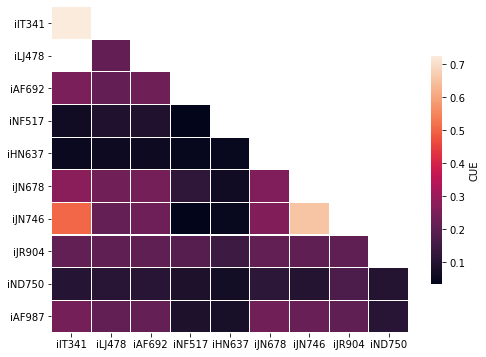

In [211]:
"""Heatmap"""
plt.figure(figsize=(8,6))
lowert = derep_cue.pivot('id1', 'id2', 'cue').loc[ids[:-1], ids].T
sns.heatmap(lowert, cbar_kws={'shrink': .7, 'label': 'CUE'}, linewidths=.1)
plt.xlabel('')
plt.ylabel('')
plt.show()

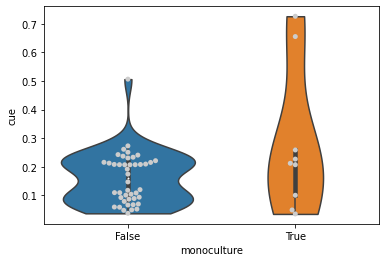

In [177]:
"""Distribution of monoculture"""
derep_cue['monoculture'] = derep_cue.id1.eq(derep_cue.id2)
kwargs = {'x': 'monoculture', 'y': 'cue', 'data': derep_cue}
sns.violinplot(**kwargs, cut=0)
sns.swarmplot(**kwargs, color='.8')
plt.show()